In [2]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import os
import torch.utils.data
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.nn import functional as F
import numpy as np
from torchvision. datasets import ImageFolder
from torchvision.utils import save_image
%matplotlib inline
cuda = torch.cuda.is_available()
if cuda:
    print('cuda is available!')
if not os.path.exists("save_image"):
    os.mkdir("save_image")
if not os.path.exists("asset"):
    os.mkdir("asset")
    
batch_size=64
z_dim=100
train_image=ImageFolder("datasets/train/",
                        transform=transforms.Compose([
                        transforms.Scale((64,64)),
                        transforms.ToTensor()]
                            ))

train_loader=DataLoader(train_image,batch_size=batch_size,shuffle=True)



{'image': 0}
torch.Size([3, 64, 64])
0.77254903 0.3372549


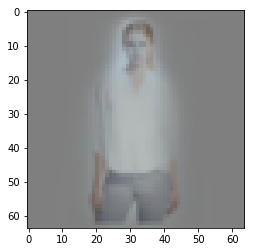

In [3]:
print( train_image.class_to_idx)
images, labels = iter(train_loader).next()
image=images[0]
print(image.size())
image_np=image.numpy()
print(image_np.max(),image_np.min())
image_np=np.transpose(image_np,(1,2,0))
plt.imshow(image_np)

In [4]:
class Discriminator(nn.Module):
    def __init__(self,input_channels,image_size):
        super(Discriminator,self).__init__()
        self.input_channels=input_channels
        self.image_size=image_size
        #(input_channels,image_size,image_size)=(3,64,64)
        self.discriminate=nn.Sequential(
            nn.Conv2d(input_channels,64,kernel_size=4,stride=2,padding=1),
            nn.LeakyReLU(),
            #(64,32,32)
            
            nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            #(128,16,16)
            
            nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            #(256,8,8)
            
            nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU()
            #(512,4,4),
            )
        
        self.dense=nn.Sequential(
            nn.Linear(4*4*512,1),
            nn.Sigmoid())
    def forward(self,x):
        batch_size=x.size()[0]
        d_pre=self.discriminate(x)
        d_pre=d_pre.view(batch_size,-1)
        out=self.dense(d_pre)
        
        return out

In [5]:
test_input=torch.ones(32,3,64,64)    
d=Discriminator(3,64)
if cuda:
    test_input=test_input.cuda()
    d=d.cuda()
output=d(test_input)
print(output.size())
print(output.max())

torch.Size([32, 1])
tensor(0.4978)


In [6]:
class Generator(nn.Module):
    def __init__(self,output_channels,z_dim):
        super(Generator,self).__init__()
        self.output_channels=output_channels
        self.z_dim=z_dim
        
        self.dense=nn.Sequential(
            nn.Linear(self.z_dim,4*4*1024)    
            )
        self.generate=nn.Sequential(
            nn.ConvTranspose2d(1024,512,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            #(512,8,8)
            
            nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            #(256,16,16)
            
            nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128,self.output_channels,kernel_size=4,stride=2,padding=1),
            nn.Sigmoid()
            )
        
        
        
    def forward(self,z):
        g_pre=self.dense(z)
        g_pre=g_pre.view(-1,1024,4,4)
        
        out=self.generate(g_pre)
        return out

In [7]:
test_input=torch.ones(32,z_dim)
g=Generator(3,z_dim)
if cuda:
    test_input=test_input.cuda()
    g=g.cuda()
out=g(test_input)

print(out.size())

torch.Size([32, 3, 64, 64])


In [37]:
G=Generator(3,z_dim)
D=Discriminator(3,batch_size)

if cuda:
    G=G.cuda()
    D=D.cuda()
G_optimizer=optim.Adam(G.parameters(),lr=0.0002,betas=(0.5,0.999))
D_optimizer=optim.Adam(D.parameters(),lr=0.0002,betas=(0.5,0.999))

loss=nn.BCELoss() #Binary Cross Entropy


In [62]:
def train():
    D.train()
    G.train()
    
    y_real=torch.ones(batch_size,1)
    y_fake=torch.zeros(batch_size,1)
    
    if cuda:
        y_real=y_real.cuda()
        y_fake=y_fake.cuda()
        
        D_loss=0
        G_loss=0
        
    for batch_idx,(data,_) in enumerate(train_loader):
        if data.size()[0]!=batch_size:
                break
            #if barch_idx%=100:
            #    print("{}/{}".format(batch_idx,len(train_loader)))
        z=torch.rand((batch_size,z_dim))
        if cuda:
            data,z=data.cuda(),z.cuda()
        D_optimizer.zero_grad()
            
        D_real=D(data)
        D_real_loss=loss(D_real,y_real)
            
        fake_image=G(z)
            
        D_fake=D(fake_image)
        D_fake_loss=loss(D_fake,y_fake)
            
        D_loss=D_real_loss+D_fake_loss
        D_loss.backward()
        D_optimizer.step()
        D_loss+=D_loss.data[0]
            
        z=torch.rand((batch_size,z_dim)) #Gの更新前にノイズを再生成する（本論文）
        if cuda:
            z=z.cuda()
            
        G_optimizer.zero_grad()
            
        fake_images=G(z)
        D_fake=D(fake_images)
        G_loss=loss(D_fake,y_real)
        G_loss.backward()
        G_optimizer.step()
        G_loss+=G_loss.data[0]
    D_loss/=len(train_loader)
    G_loss/=len(train_loader)
    return D_loss,G_loss




In [63]:
def generate_image(epoch):
    test_z=torch.rand((batch_size,z_dim))
    if cuda:
        test_z=test_z.cuda()
    g_image=G(test_z).data.cpu()
    save_image(g_image,"save_image/epoch_{}.png".format(epoch))
    print("save_image!!")

In [ ]:
d_loss_list=[]
g_loss_list=[]
total_loss_list=[]
num_epoch=200

for epoch in range(1,num_epoch+1):
    if epoch==1:
        print("trainning start!!")
    d_loss,g_loss=train()
    total_loss=d_loss+g_loss
    print("epoch [{}/{}],--d_loss:{:.4f}--g_loss:{:.4f}--total_loss:{:.4f}".format(epoch,num_epoch,
                                                               d_loss,g_loss,total_loss))
    d_loss_list.append(d_loss)
    g_loss_list.append(g_loss)
    total_loss_list.append(total_loss)
    
    if epoch%1==0:
        generate_image(epoch)
        torch.save(G.state_dict(),"asset/G_epoch{}.pth".format(epoch))
        torch.save(D.state_dict(),"asset/D_epoch{}.pth".format(epoch))
    
np.save("asset/d_loss_list.npy",np.array(d_loss_list))
np.save("asset/g_loss_list.npy",np.array(g_loss_list))
np.save("asset/total_loss_list.npy",np.array(total_loss_list))